In [60]:
from openfermion import get_sparse_operator
import numpy as np
import pandas as pd
from numpy.linalg import eigh
from numpy.random import randn
from utlis import *

In [77]:
# Simulate time evolution
# System definition
chain_length = 5
couplings = [1., 2., 1.5]
hh = create_heizenberg_h(couplings, n_spins=chain_length)

# Diagonalization
hh_matrix_sp = get_sparse_operator(hh, n_qubits=5)
hh_matrix = hh_matrix_sp.toarray()

assert np.allclose(hh_matrix, hh_matrix.T)
e, v = eigh(hh_matrix)
t_total = 10. / (np.max(e) - np.min(e))

# Parameters
n_trotter_max = 20
init_state = randn(2**chain_length)
init_state /= np.sqrt(np.dot(init_state, init_state))

# Exact propagator
prop_exact = create_exact_propagator(hh, t_total)
time_evolved_state = prop_exact @ init_state

# Simulation
results = []
for n_trotter in range(1, n_trotter_max + 1):
    time_step = t_total / n_trotter
    prop1 = trotterized_propagator1(couplings, chain_length, time_step)
    prop2 = trotterized_propagator2(couplings, chain_length, time_step)
    
    state1 = np.copy(init_state)
    state2 = np.copy(init_state)
    
    # Apply propagators
    for _ in range(n_trotter):
        state1 = prop1 @ state1
        state2 = prop2 @ state2
        
    error1  = np.sqrt(np.dot(np.conj(state1 - time_evolved_state), state1 - time_evolved_state))
    results.append(
        {'num_trotter' : n_trotter, 'error' : error1, 'method' : 'Method1'}
    )
    error2  = np.sqrt(np.dot(np.conj(state2 - time_evolved_state), state2 - time_evolved_state))
    results.append(
        {'num_trotter' : n_trotter, 'error' : error2, 'method' : 'Method2'}
    )
    
results = pd.DataFrame(results)

In [78]:
results.head()

,num_trotter,error,method
0,1,1.162370+0.000000j,Method1
1,1,0.946087+0.000000j,Method2
2,2,0.622159+0.000000j,Method1
3,2,0.423561+0.000000j,Method2
4,3,0.421134+0.000000j,Method1


In [79]:
results_method1 = results.query('method == "Method1"')
results_method2 = results.query('method == "Method2"')

/home/akunitsa/local/miniconda3/envs/ionq/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/akunitsa/local/miniconda3/envs/ionq/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/akunitsa/local/miniconda3/envs/ionq/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/akunitsa/local/miniconda3/envs/ionq/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<Axes: xlabel='num_trotter', ylabel='Trotter error'>

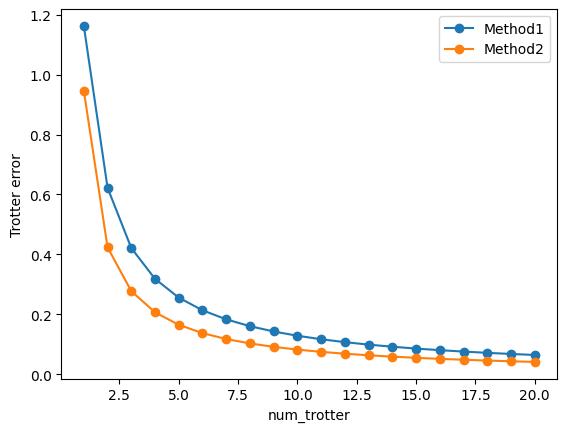

In [80]:
ax = results_method1.plot(x='num_trotter', y='error', ylabel='Trotter error', marker='o', label='Method1')
results_method2.plot(x='num_trotter', y='error', marker='o', label='Method2', ax=ax)